In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from pygam import LinearGAM, s, f, te

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Import the dataset
import os
FIGURE_DIR = os.path.join("..", "outputs", "figures")
os.makedirs(FIGURE_DIR, exist_ok=True)

path_to_data = os.path.join("..", "data", "Hourly_AQI_EPA.xlsb")
df = pd.read_excel(path_to_data)

# Convert the date to YYYY-MM-DD
df = df.rename(columns={'0xf': 'Date'})
df['Date'] = pd.to_datetime(
    df['Date'].astype(float),
    unit='D',
    origin='1899-12-30',
    errors='coerce'
)

NameError: name 'os' is not defined

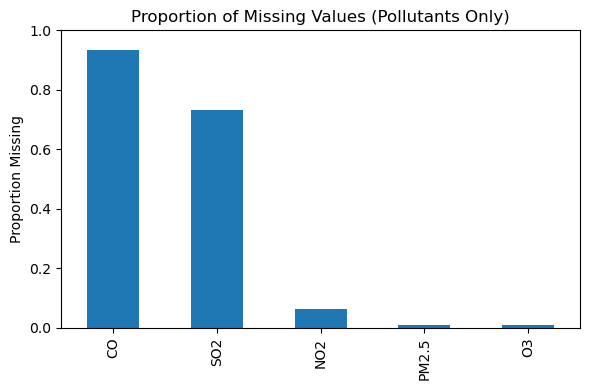

In [ ]:
# Visualization 1: Missing Values of the Pollutants
pollutants = ['CO', 'NO2', 'O3', 'PM2.5', 'SO2']

missing_pct = df[pollutants].isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
missing_pct.plot(kind='bar')
plt.title("Proportion of Missing Values (Pollutants Only)")
plt.ylabel("Proportion Missing")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig1_missing_values.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Missing percentage by pollutant:")
print((missing_pct * 100).round(2))

In [ ]:
# Model 1 (baseline model): Mixed Effects Model
df['Is_Weekend'] = (df['Day_Type'] == 'Weekend').astype(int)

# Visualization 2: Average AQI by Hour (All Stations in Ontario)
plt.figure(figsize=(8,5))
hourly_mean = df.groupby('Hour')['Max_AQI'].mean()
sns.lineplot(x=hourly_mean.index, y=hourly_mean.values)
plt.title("Average Max_AQI by Hour of Day Across All Stations in Ontario")
plt.xlabel("Hour")
plt.ylabel("Average Max_AQI")
plt.xticks(range(0,24))
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig2_hourly_aqi.png"), dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: Hourly Pattern (Weekday vs Weekend)
plt.figure(figsize=(6,4))
sns.lineplot(data=df,
             x='Hour',
             y='Max_AQI',
             hue='Day_Type',
             estimator='mean')
plt.title("Hourly AQI in Weekday vs Weekend Across All Stations in Ontario")
plt.xticks(range(0,24))
plt.tight_layout()
plt.grid(True)
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig3_weekday_weekend.png"), dpi=300, bbox_inches='tight')
plt.show()

lmm = smf.mixedlm(
    "Max_AQI ~ Hour + Is_Weekend + Season",
    data=df,
    groups=df["Station ID"]
)

lmm_result = lmm.fit()
print(lmm_result.summary())

# Visualization 4: Mixed Model Residual Diagnostics
residuals = lmm_result.resid
fitted = lmm_result.fittedvalues

plt.figure(figsize=(5,3))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Fitted Values (Mixed Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig4_residuals.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Model 2 (inference model): GAM with nonlinear interactions
df['Season'] = df['Season'].astype('category')
df['Season_Code'] = df['Season'].cat.codes
df['Station Name'] = df['Station Name'].astype('category')
df['Station_Code'] = df['Station Name'].cat.codes

X = df[['Hour', 'Season_Code', 'Is_Weekend', 'Station_Code']].values
y = df['Max_AQI'].values

gam = LinearGAM(
    s(0, n_splines=24) +          # nonlinear hour effect
    te(0, 1, n_splines=[24, 4]) + # hour × season interaction
    f(2) +                       # weekend effect
    f(3)                         # station fixed effect
)

gam.fit(X, y)
gam.summary()

In [ ]:
# Station specific daily pattern by mixed effect model
from patsy import dmatrix

# Create spline basis for hour
hour_spline = dmatrix(
    "bs(Hour, df=6, degree=3, include_intercept=False)",
    df,
    return_type='dataframe'
)

df = pd.concat([df, hour_spline], axis=1)

import statsmodels.formula.api as smf

formula = """
Max_AQI ~ 
bs(Hour, df=6, degree=3) +
C(Season) +
C(Day_Type)
"""

model = smf.mixedlm(
    formula,
    df,
    groups=df["Station ID"]
)


result = model.fit()
print(result.summary())

In [ ]:
# Visualization 6: Average Daily AQI Pattern by Season
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df,
    x='Hour',
    y='Max_AQI',
    hue='Season',
    errorbar=None
)
plt.title("Average Daily AQI Pattern by Season")
plt.grid(True)
plt.legend(loc='upper right')
plt.xticks(range(0,24))
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig5_seasonal_pattern.png"), dpi=300, bbox_inches='tight')
plt.show()

# Visualization 8: 10 Station-Specific Daily Patterns
selected_stations = df['Station ID'].unique()[:10]

g = sns.FacetGrid(df[df['Station ID'].isin(selected_stations)],
                  col="Station ID",
                  col_wrap=2,
                  height=4)

g.map_dataframe(sns.lineplot,
                x="Hour",
                y="Max_AQI",
                estimator='mean')

g.set_titles("Station {col_name}")
g.set_axis_labels("Hour", "Average Max_AQI")
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig6_station_patterns.png"), dpi=300, bbox_inches='tight')
plt.show()

# Visualization 9: Weekday vs Weekend across Seasons
g = sns.FacetGrid(
    df,
    col="Season",
    col_order=["Spring", "Summer", "Fall", "Winter"],
    height=4,
    aspect=1.2,
    sharey=True
)

g.map_dataframe(
    sns.lineplot,
    x="Hour",
    y="Max_AQI",
    hue="Day_Type",
    estimator="mean",
    errorbar=None
)

# Axis formatting
g.set_axis_labels("Hour of Day (0–23)", "Average Maximum AQI (Index Units)")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.set_xticks(range(0, 24, 3))
    ax.set_xlim(0, 23)
    ax.grid(True, linestyle="--", alpha=0.4)

# Adjust legend
g.add_legend(title="Day Type")
g._legend.set_bbox_to_anchor((1.02, 0.5))
g._legend.set_frame_on(False)

# Expand figure width for single row layout
g.fig.set_size_inches(18, 4)

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "q2_fig7_weekday_weekend_season.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
features = [
    'Hour', 'Is_Weekend', 'Season_Code', 'Station_Code',
    'CO', 'NO2', 'O3', 'PM2.5', 'SO2'
]

X_ml = df[features]
y_ml = df['Max_AQI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42
)

# Fit model
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost RMSE: {rmse:.4f}")